# 自注意力和位置编码
在深度学习中，经常使⽤卷积神经⽹络（CNN）或循环神经⽹络（RNN）对序列进⾏编码。想象⼀下，有了注意⼒机制之后，我们将词元序列输⼊注意⼒池化中，以便同⼀组词元同时充当查询、键和值。具体来说，每个查询都会关注所有的键－值对并⽣成⼀个注意⼒输出。由于查询、键和值来⾃同⼀组输⼊，因此被称为 ⾃注
意⼒（self-attention）(Lin et al., 2017, Vaswani et al., 2017)，也被称为内部注意⼒（intra-attention）(Cheng
et al., 2016, Parikh et al., 2016, Paulus et al., 2017)。本节将使⽤⾃注意⼒进⾏序列编码，以及如何使⽤序列的顺序作为补充信息。


In [1]:
import math
import torch
from torch import nn
from d2l import torch as d2l

## 1. 自注意力
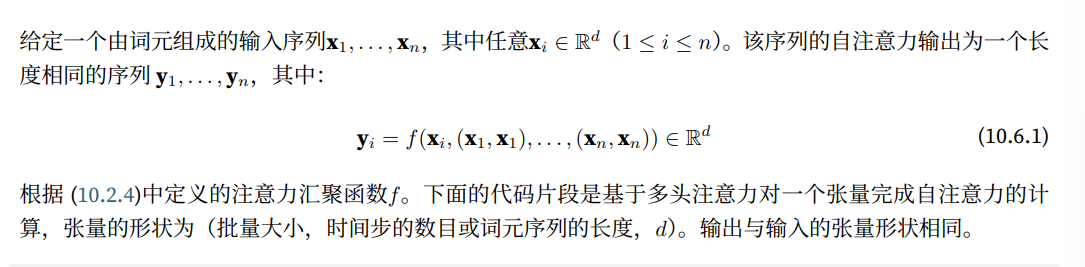

In [2]:
num_hiddens, num_heads = 100, 5
attention = d2l.MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                  num_hiddens, num_heads, 0.5)
attention.eval()

MultiHeadAttention(
  (attention): DotProductAttention(
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (W_q): Linear(in_features=100, out_features=100, bias=False)
  (W_k): Linear(in_features=100, out_features=100, bias=False)
  (W_v): Linear(in_features=100, out_features=100, bias=False)
  (W_o): Linear(in_features=100, out_features=100, bias=False)
)

In [3]:
batch_size, num_queries, valid_len = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_len).shape

torch.Size([2, 4, 100])

## 2. 比较cnn rnn self-attention
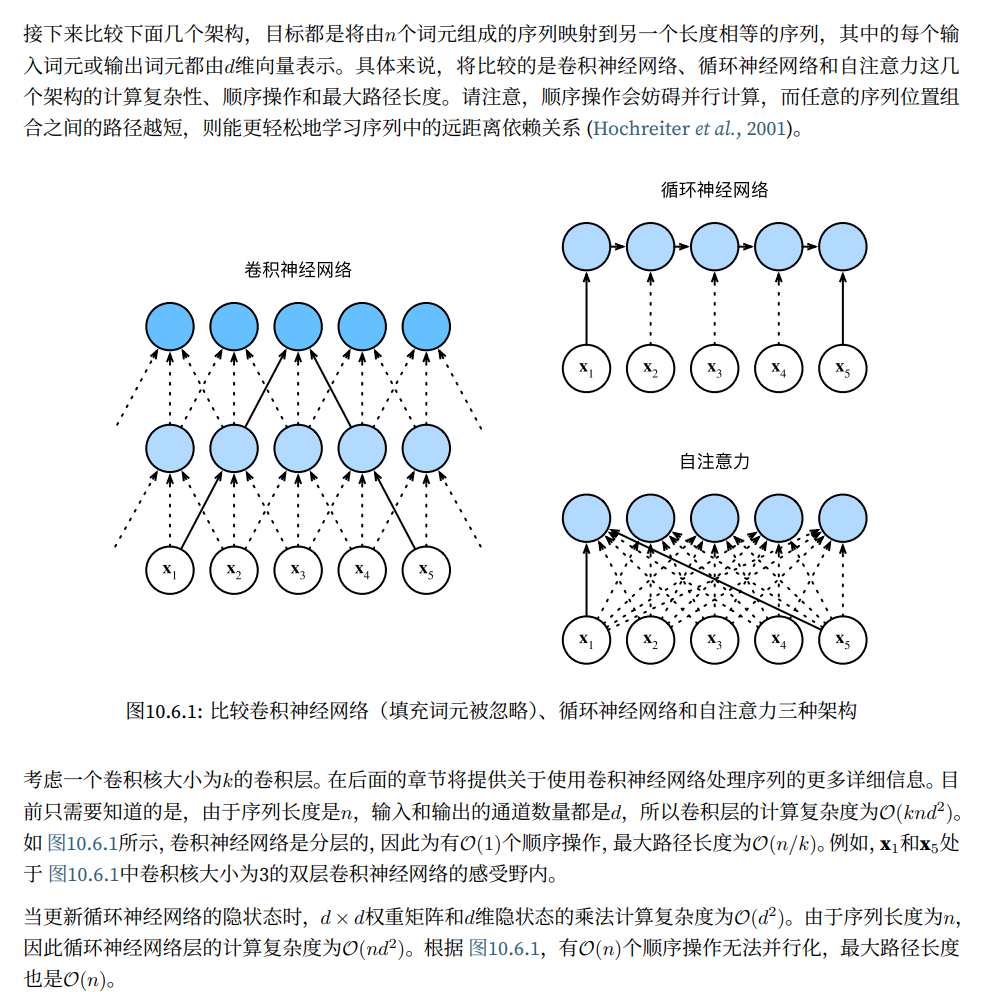
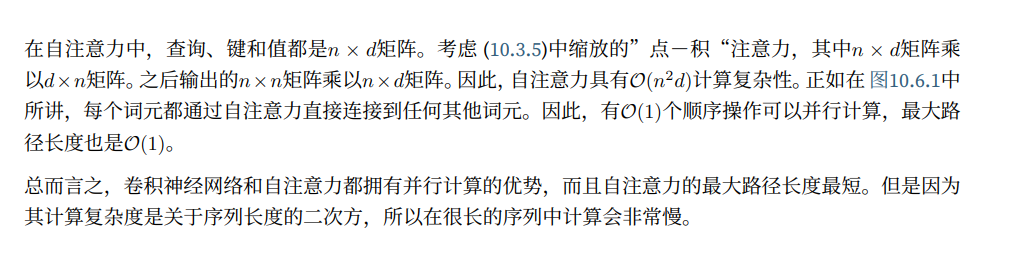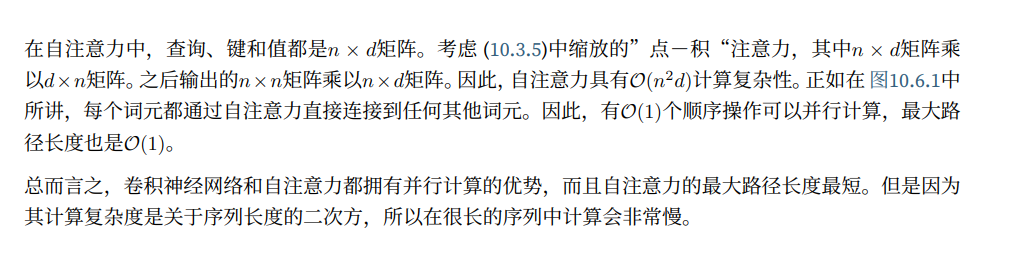

+ 这里的最长长度是指信息传递的长度，从第一个到最后一个（cv中也称为field）
+ attention很适合处理较长序列，可以很快抓取距离较远的信息，模型可以看到比较宽的信息（Transformer，Bert，GPT）

## 3. 位置编码
在处理词元序列时，循环神经⽹络是逐个的重复地处理词元的，⽽⾃注意⼒则因为并⾏计算⽽放弃了顺序操
作。为了使⽤序列的顺序信息，通过在输⼊表⽰中添加 位置编码（positional encoding）来注⼊绝对的或相
对的位置信息。位置编码可以通过学习得到也可以直接固定得到。

In [4]:
#@save
class PositionalEncoding(nn.Module):
    #位置编码
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # 创建一个足够长的Position
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)
        
    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

在位置嵌⼊矩阵P中，⾏代表词元在序列中的位置，列代表位置编码的不同维度。从下⾯的例⼦中可以看到位
置嵌⼊矩阵的第6列和第7列的频率⾼于第8列和第9列。第6列和第7列之间的偏移量（第8列和第9列相同）是
由于正弦函数和余弦函数的交替。

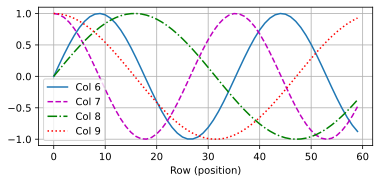

In [5]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.P[:, :X.shape[1], :]
d2l.plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
        figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])


+ 绝对位置信息

In [6]:
for i in range(8):
    print(f'{i}的⼆进制是：{i:>03b}')


0的⼆进制是：000
1的⼆进制是：001
2的⼆进制是：010
3的⼆进制是：011
4的⼆进制是：100
5的⼆进制是：101
6的⼆进制是：110
7的⼆进制是：111


在⼆进制表⽰中，较⾼⽐特位的交替频率低于较低⽐特位，与下⾯的热图所⽰相似，只是位置编码通过使⽤三⻆函数在编码维度上降低频率。由于输出是浮点数，因此此类连续表⽰⽐⼆进制表⽰法更节省空间。

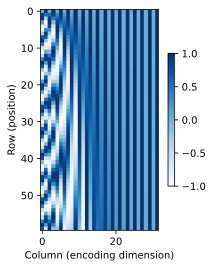

In [7]:
P = P[0, :, :].unsqueeze(0).unsqueeze(0)
d2l.show_heatmaps(P, xlabel='Column (encoding dimension)',
                    ylabel='Row (position)', figsize=(3.5, 4), cmap='Blues')


+ 相对位置信息
除了捕获绝对位置信息之外，上述的位置编码还允许模型学习得到输⼊序列中相对位置信息。这是因为对于任何确定的位置偏移δ，位置i + δ处的位置编码可以线性投影位置i处的位置编码来表⽰。

## 总结
+ 在⾃注意⼒中，查询、键和值都来⾃同⼀组输⼊。
+ 卷积神经⽹络和⾃注意⼒都拥有并⾏计算的优势，⽽且⾃注意⼒的最⼤路径⻓度最短。但是因为其计
算复杂度是关于序列⻓度的⼆次⽅，所以在很⻓的序列中计算会⾮常慢。
+ 为了使⽤序列的顺序信息，可以通过在输⼊表⽰中添加位置编码，来注⼊绝对的或相对的位置信息。
